In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [117]:
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.metrics import explained_variance_score,mean_absolute_error,mean_squared_error,median_absolute_error,r2_score
from sklearn.ensemble import RandomForestRegressor #RF
import xgboost as xgb #XGBoost

In [118]:
#导入数据
data = pd.read_csv(r'E:\Python\learning\teddy\order_train1.csv')


In [119]:
#训练数据处理
# import chinese_calendar
data["order_date"]=data["order_date"].apply(pd.to_datetime,format='%Y-%m-%d')
data['Year'] = data.order_date.dt.year
data["quarter"] = data['order_date'].dt.quarter
data['Month'] = data.order_date.dt.month

dic = {"offline":1,"online":0}
data['sales_chan_name'] = data['sales_chan_name'].map(dic)
print(data.shape)

(597694, 11)


In [120]:
print(data.head(1).T)

                                     0
order_date         2015-09-01 00:00:00
sales_region_code                  104
item_code                        22069
first_cate_code                    307
second_cate_code                   403
sales_chan_name                      1
item_price                      1114.0
ord_qty                             19
Year                              2015
quarter                              3
Month                                9


In [121]:
data=data.drop('order_date',axis=1)
print(data.shape)

(597694, 10)


In [122]:
print(data.dtypes)

sales_region_code      int64
item_code              int64
first_cate_code        int64
second_cate_code       int64
sales_chan_name        int64
item_price           float64
ord_qty                int64
Year                   int64
quarter                int64
Month                  int64
dtype: object


In [123]:
#图片中文乱码
import matplotlib as mpl
mpl.style.use('seaborn')
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
sns.set(font='SimHei',font_scale=1.5)

In [124]:
#数据
data_train=data.groupby(['sales_region_code', 'first_cate_code','second_cate_code','item_code']).mean().reset_index()
print(data_train.head(2).T)
print(data_train.shape)

                              0            1
sales_region_code    101.000000    101.00000
first_cate_code      301.000000    301.00000
second_cate_code     405.000000    405.00000
item_code          20003.000000  20027.00000
sales_chan_name        0.910714      1.00000
item_price           779.991071    892.93750
ord_qty               93.000000     20.12500
Year                2017.544643   2017.06250
quarter                2.357143      1.75000
Month                  6.008929      4.03125
(5366, 10)


In [125]:
#划分训练-预测集
X = data_train[['sales_region_code', 'first_cate_code', 'second_cate_code', 'item_code']].values
y = data_train[['ord_qty']].values
print(X.shape,y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(5366, 4) (5366, 1)
(4292, 4) (4292, 1) (1074, 4) (1074, 1)


In [126]:
#标准化
from sklearn.preprocessing import StandardScaler
ss_x = StandardScaler()
X_train = ss_x.fit_transform(X_train)
X_test = ss_x.transform(X_test)
ss_y = StandardScaler()
y_train = ss_y.fit_transform(y_train.reshape(-1, 1)).ravel()
y_test = ss_y.transform(y_test.reshape(-1, 1)).ravel()


In [152]:
#机器学习模型对比
def model_(ml_model,title):
    ml_model.fit(X_train,y_train)
    r2 = ml_model.score(X_train,y_train)
    y_predict = ml_model.predict(X_test)
    print("测试集均方差MSE为{}".format(mean_squared_error(ss_y.inverse_transform(y_test.reshape(-1, 1)), ss_y.inverse_transform(y_predict.reshape(-1, 1)))))
    print('测试集平均绝对误差MAE:{}'.format(mean_absolute_error(ss_y.inverse_transform(y_test.reshape(-1, 1)), ss_y.inverse_transform(y_predict.reshape(-1, 1)))))
    print('测试集均方差为{}'.format(mean_squared_error(y_test,y_predict)))
    print('测试集平均绝对误差为{}'.format(mean_absolute_error(y_test,y_predict)))
    print("拟合优度为{}".format(r2))
    plt.figure(figsize=(15,10))
    plt.plot(np.arange(len(y_predict)),ss_y.inverse_transform(y_test.reshape(-1,1)),"go-",label='真实值')
    plt.plot(np.arange(len(y_predict)),ss_y.inverse_transform(y_predict.reshape(-1,1)),"rp-",label='预测值')
    plt.title(f"{title}预测集--r^2为{r2}")
    plt.xlabel('样本数')
    plt.ylabel('需求量')
    plt.legend(loc='best')
    # plt.show()
def pic(ml_model,title):
    plt.figure(figsize=(15,10))
    y_train_pre=rf.predict(X_train)
    plt.plot(np.arange(len(y_train)), ss_y.inverse_transform(y_train.reshape(-1, 1)), 'go-', label="真实值")
    plt.plot(np.arange(len(y_train)), ss_y.inverse_transform(y_train_pre.reshape(-1, 1)), 'rp-', label="预测值")
    plt.title(f"{title}训练集")
    plt.xlabel('样本数')
    plt.ylabel('需求量')
    plt.legend(loc='best')
    # plt.show()


xgb拟合优度R^2为: 1.00
测试集均方差MSE为11817.424842244554
测试集平均绝对误差MAE:44.45697408232445
测试集均方差为0.8492832628357702
测试集平均绝对误差为0.3768814460802818
拟合优度为0.995033870944543


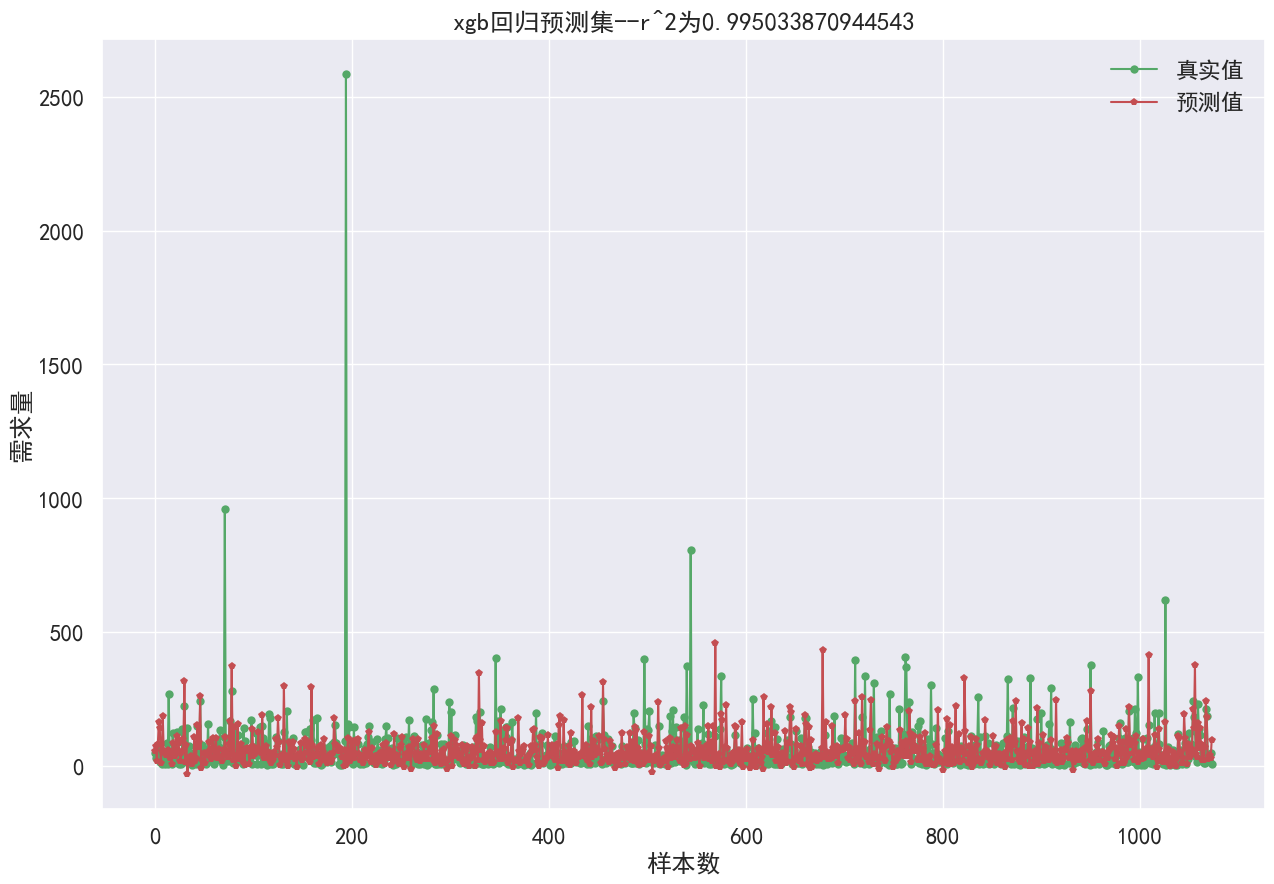

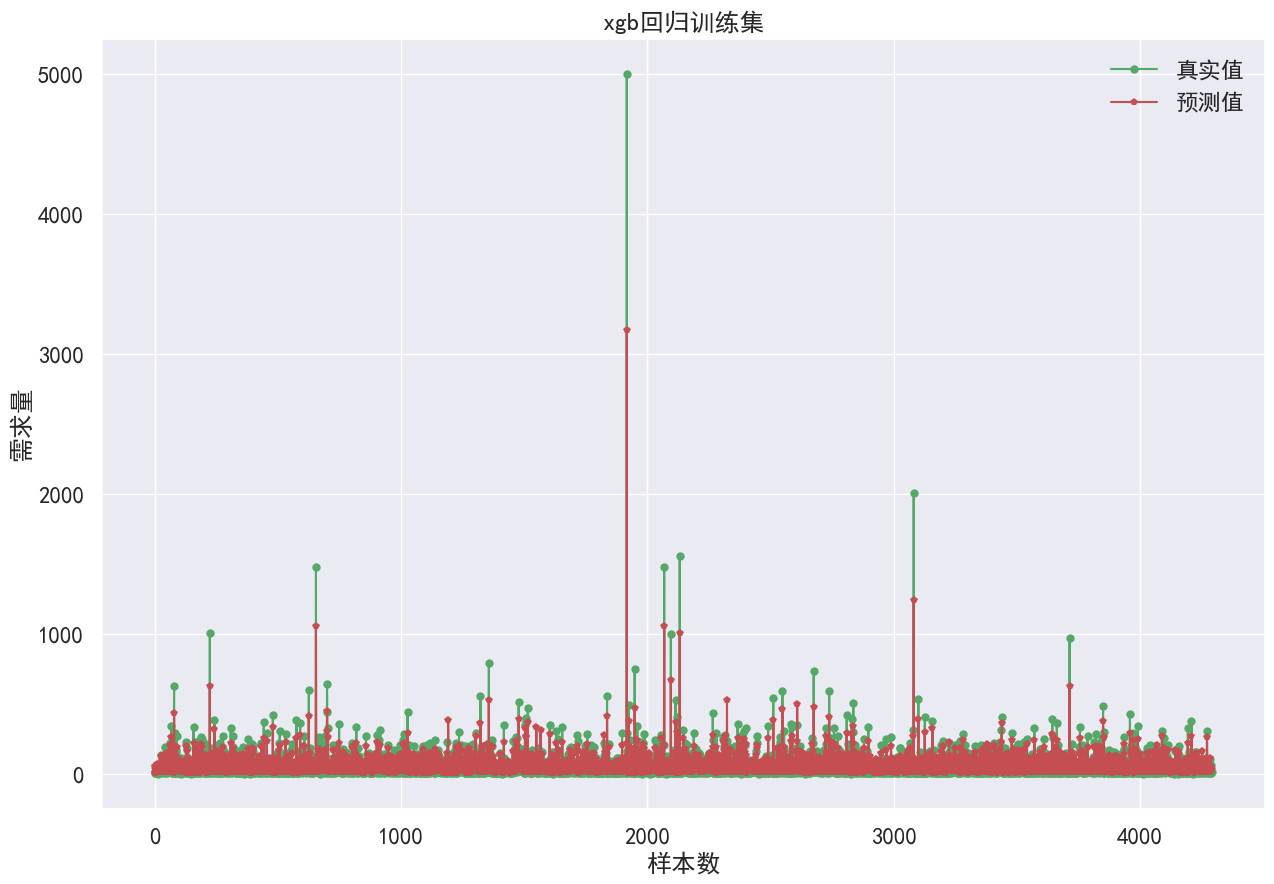

rf拟合优度R^2为: 0.86
测试集均方差MSE为12072.147312657458
测试集平均绝对误差MAE:47.126968830667444
测试集均方差为0.8675894101187862
测试集平均绝对误差为0.3995161732616993
拟合优度为0.855594391348144


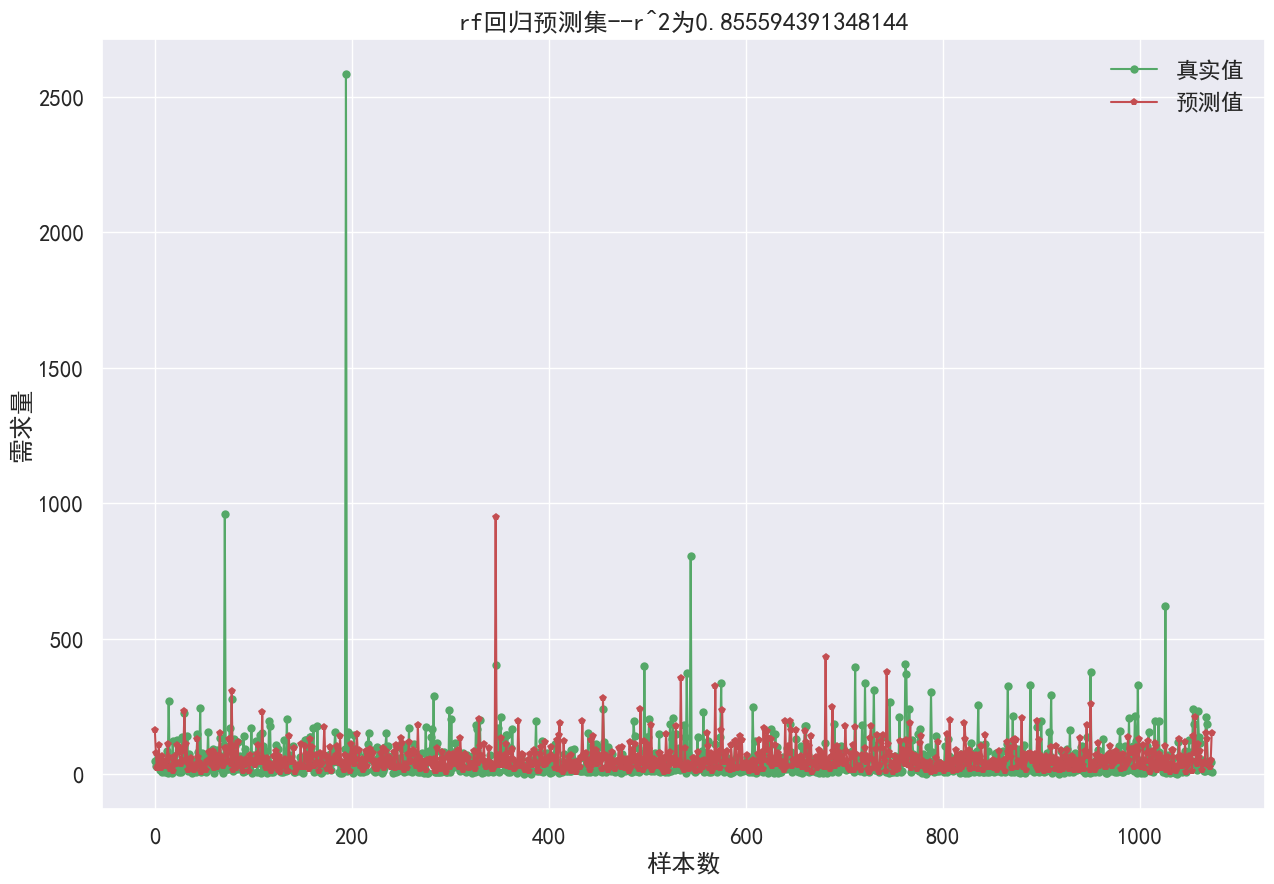

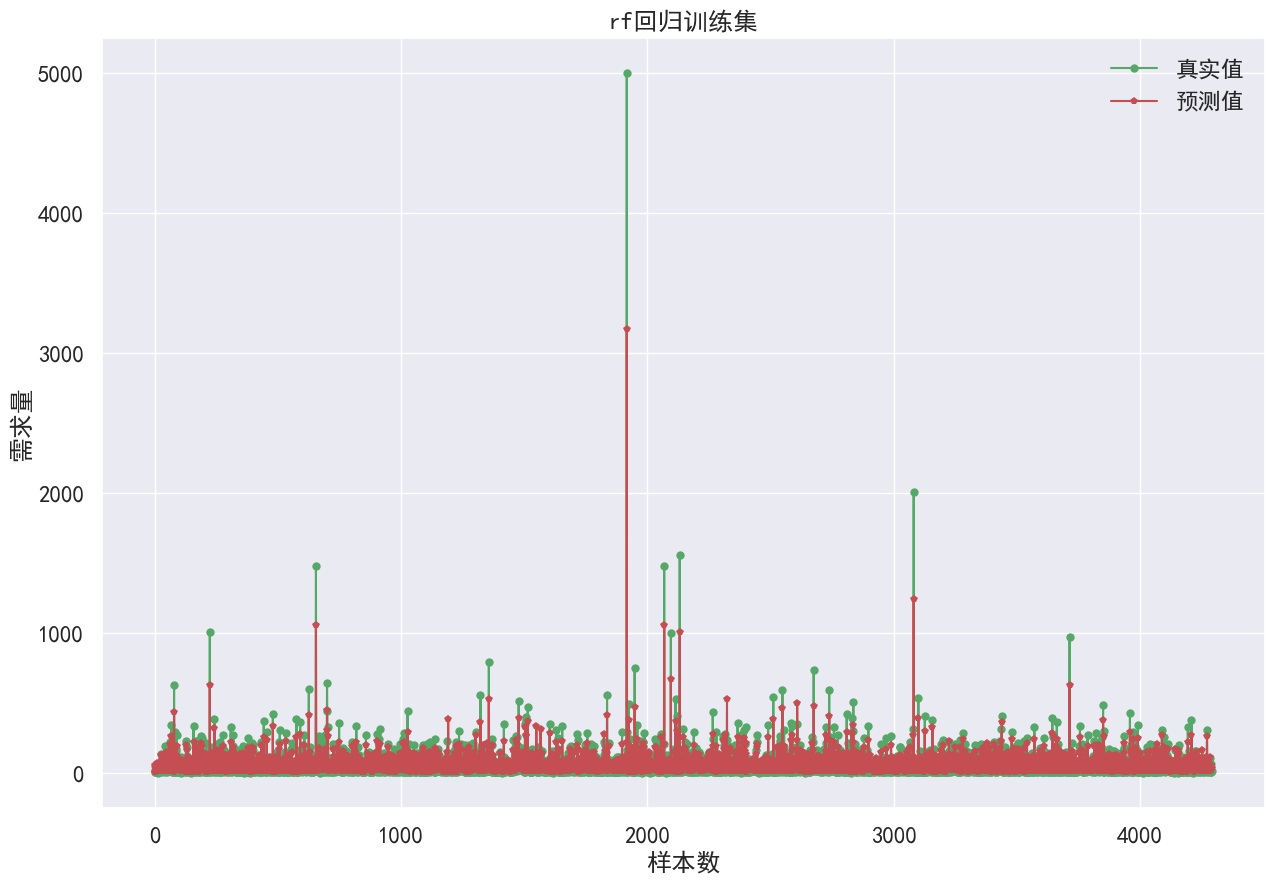

In [158]:
#模型
#xgb
XGB=xgb.XGBRegressor(n_estimators = 200,learning_rate=0.3,max_depth=10,random_state = 11)
XGB.fit(X_train, y_train)
print('xgb拟合优度R^2为: {:.2f}'.format(XGB.score(X_train, y_train)))
model_(XGB,'xgb回归')
plt.savefig('xgb1')
plt.show()
pic(XGB,'xgb回归')
plt.savefig('xgb2')
plt.show()

#rf
rf = RandomForestRegressor(n_estimators = 200,oob_score = True, bootstrap = True, n_jobs = -1,random_state = 11)
rf.fit(X_train, y_train)
print('rf拟合优度R^2为: {:.2f}'.format(rf.score(X_train, y_train)))
model_(rf,'rf回归')
plt.savefig('rf1')
plt.show()
pic(rf,'rf回归')
plt.savefig('rf2')
plt.show()


In [159]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': -1,
 'oob_score': True,
 'random_state': 11,
 'verbose': 0,
 'warm_start': False}

In [160]:
XGB.get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.3,
 'max_bin': 256,
 'max_cat_threshold': 64,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 10,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 200,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 11,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}